# Autoencoders

This notebook contains two example autoencoders, the first trained on MNIST and the second trained on CIFAR-10.  An autoencoder is neural network consisting of two parts: an encoder and a decoder.  As can be seen in the image below, the encoder compresses a given input to code.  This code part of the network is often called the bottleneck.  The decoder takes this code and produces an output.  

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" width=500>

The output should be the same as the input and is leart using mean squared error loss:

$$ \mathcal{L} = \| input - output \|^2 $$

Since the bottleneck has a lower dimensionality than the input or output, the learning process forces the network to compress our input in a way that losses a little information as possible.  The more information that is retrained during the encoding, the better our output will be.

# MNIST

## Setup

Import python libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

Are we using a GPU or a CPU?

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

We will use the MNIST dataset which contains 10,000s of $28 \times 28$ resolution images.

In [15]:
# Load MNIST dataset with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 64
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

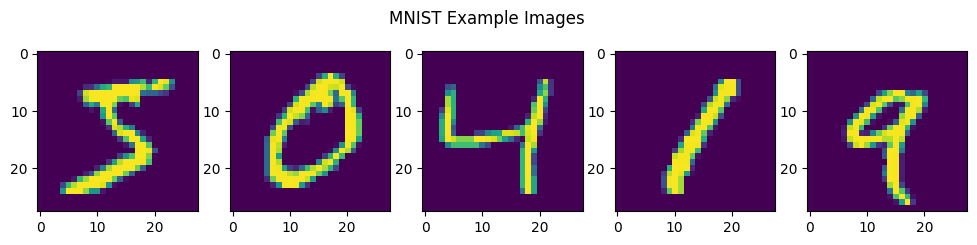

In [16]:
# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('MNIST Example Images')
ax[0].imshow(mnist_dataset[0][0][0,:,:].numpy())
ax[1].imshow(mnist_dataset[1][0][0,:,:].numpy())
ax[2].imshow(mnist_dataset[2][0][0,:,:].numpy())
ax[3].imshow(mnist_dataset[3][0][0,:,:].numpy())
ax[4].imshow(mnist_dataset[4][0][0,:,:].numpy())


## Neural Network



We will be using a simple AutoEncoder here.  This network uses a combination of linear and convolution layers to compress an image into a smaller respresentation, then uses a decoder to network to reconstruct the image from this compressed representation.

In [17]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels, img_size, latent_dim=128):
        super(Autoencoder, self).__init__()

        # What is the dimension of our image after going through the encoder?
        downsampled_size = int(img_size / 4)

        # Encoder
        self.encoder = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 7x7

            # Flatten and dense layers
            nn.Flatten(),
            nn.Linear(64 * downsampled_size * downsampled_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            # Dense layers
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * downsampled_size * downsampled_size),
            nn.ReLU(),

            # Reshape layer
            nn.Unflatten(1, (64, downsampled_size, downsampled_size)),

            # First conv transpose block
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),  # 14x14
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Second conv transpose block
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),  # 28x28
            nn.ReLU(),
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction


## Training

Train our autoencoder to reconstruct MNIST images.

In [18]:
# Hyperparameters
epochs=20
learning_rate=1e-4

# Initialize model, loss, and optimizer
img_size = 28
in_channels = 1
mnist_model = Autoencoder(in_channels, img_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mnist_model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    for data in mnist_loader:
        # Sample data from dataset
        img, _ = data
        img = img.to(device)

        # Forward pass
        output = mnist_model(img)
        loss = criterion(output, img)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Log the loss for this epoch
    avg_loss = total_loss/len(mnist_loader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

Epoch [1/20], Loss: 0.068993
Epoch [2/20], Loss: 0.025493
Epoch [3/20], Loss: 0.015298
Epoch [4/20], Loss: 0.011218
Epoch [5/20], Loss: 0.009294
Epoch [6/20], Loss: 0.008033
Epoch [7/20], Loss: 0.007125
Epoch [8/20], Loss: 0.006478
Epoch [9/20], Loss: 0.005968
Epoch [10/20], Loss: 0.005540
Epoch [11/20], Loss: 0.005176
Epoch [12/20], Loss: 0.004858
Epoch [13/20], Loss: 0.004591
Epoch [14/20], Loss: 0.004363
Epoch [15/20], Loss: 0.004170
Epoch [16/20], Loss: 0.003995
Epoch [17/20], Loss: 0.003847
Epoch [18/20], Loss: 0.003706
Epoch [19/20], Loss: 0.003578
Epoch [20/20], Loss: 0.003462


Text(0.5, 1.0, 'MNIST Training Loss')

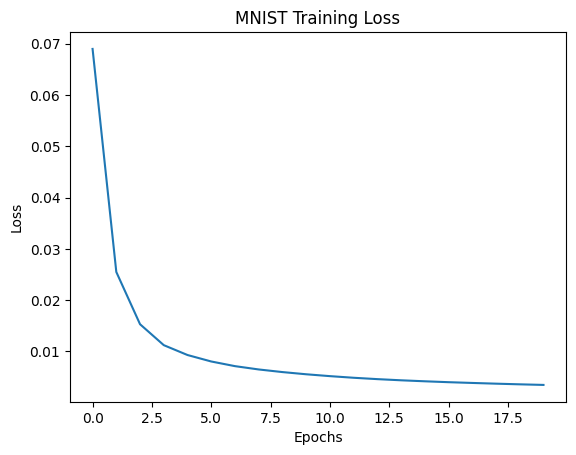

In [19]:
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MNIST Training Loss')

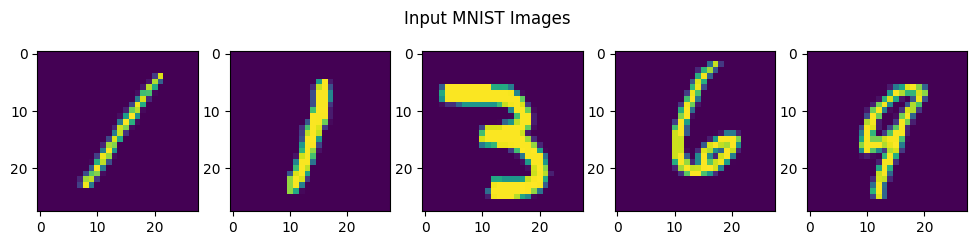

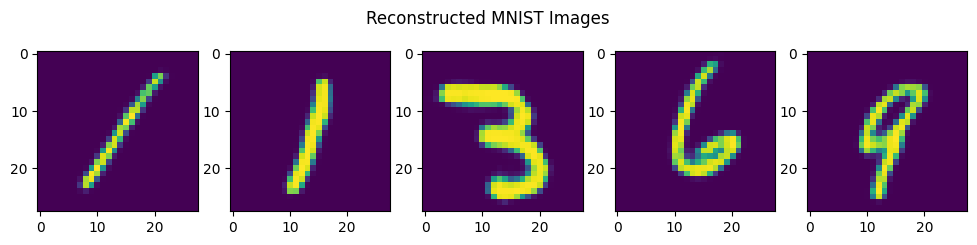

In [20]:
# Plot starting examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('Input MNIST Images')
ax[0].imshow(img[0,0,:,:].cpu().numpy())
ax[1].imshow(img[1,0,:,:].cpu().numpy())
ax[2].imshow(img[2,0,:,:].cpu().numpy())
ax[3].imshow(img[3,0,:,:].cpu().numpy())
ax[4].imshow(img[4,0,:,:].cpu().numpy())
plt.show()

# Run images though the autoencdoer
output = mnist_model(img)

# Plot reconstructed images
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('Reconstructed MNIST Images')
ax[0].imshow(output[0,0,:,:].detach().cpu().numpy())
ax[1].imshow(output[1,0,:,:].detach().cpu().numpy())
ax[2].imshow(output[2,0,:,:].detach().cpu().numpy())
ax[3].imshow(output[3,0,:,:].detach().cpu().numpy())
ax[4].imshow(output[4,0,:,:].detach().cpu().numpy())
plt.show()

# CIFAR-10

## Dataset

Our second dataset the CIFAR-10 dataset.

In [21]:
# Load CIFAR-10 dataset with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 64
cifar_dataset = datasets.CIFAR10(
    root='./data',  # Data will be downloaded to this directory
    train=True,     # Specify that we want the training dataset
    download=True,  # Download the dataset if it's not already downloaded
    transform=transform
)
cifar_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


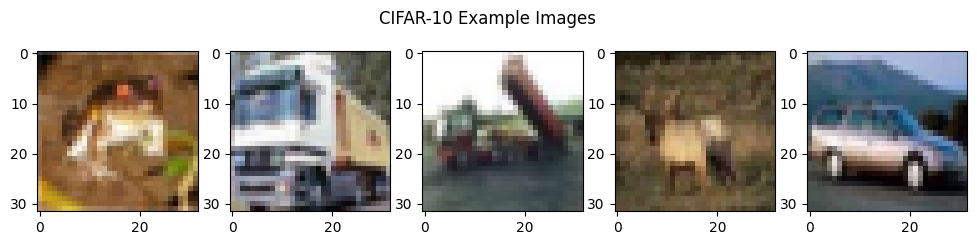

In [22]:
# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('CIFAR-10 Example Images')
ax[0].imshow(np.transpose(cifar_dataset[0][0].numpy(), (1,2,0)))
ax[1].imshow(np.transpose(cifar_dataset[1][0].numpy(), (1,2,0)))
ax[2].imshow(np.transpose(cifar_dataset[2][0].numpy(), (1,2,0)))
ax[3].imshow(np.transpose(cifar_dataset[3][0].numpy(), (1,2,0)))
ax[4].imshow(np.transpose(cifar_dataset[4][0].numpy(), (1,2,0)))


## Training

New we will train another autoencoder on the CIFAR-10 dataset.

In [23]:
# Hyperparameters
epochs=20
learning_rate=1e-4

# Initialize model, loss, and optimizer
img_size = 32
in_channels = 3
cifar_model = Autoencoder(in_channels, img_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cifar_model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    for data in cifar_loader:

        # Sample data from dataset
        img, _ = data
        img = img.to(device)

        # Forward pass
        output = cifar_model(img)
        loss = criterion(output, img)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Log the loss for this epoch
    avg_loss = total_loss/len(cifar_loader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

Epoch [1/20], Loss: 0.036945
Epoch [2/20], Loss: 0.020831
Epoch [3/20], Loss: 0.017830
Epoch [4/20], Loss: 0.016146
Epoch [5/20], Loss: 0.013399
Epoch [6/20], Loss: 0.012406
Epoch [7/20], Loss: 0.011671
Epoch [8/20], Loss: 0.011090
Epoch [9/20], Loss: 0.010624
Epoch [10/20], Loss: 0.010270
Epoch [11/20], Loss: 0.009980
Epoch [12/20], Loss: 0.009706
Epoch [13/20], Loss: 0.009440
Epoch [14/20], Loss: 0.009221
Epoch [15/20], Loss: 0.009009
Epoch [16/20], Loss: 0.008820
Epoch [17/20], Loss: 0.008634
Epoch [18/20], Loss: 0.008491
Epoch [19/20], Loss: 0.008335
Epoch [20/20], Loss: 0.008204


Text(0.5, 1.0, 'CIFAR-10 Training Loss')

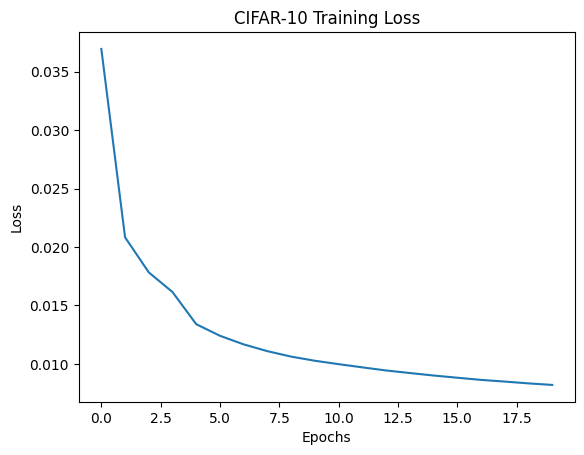

In [24]:
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CIFAR-10 Training Loss')

Here we plot input images, and the image reconstructed by the autoencoder.  Since CIFAR-10 is a more complexe dataset than MNIST, results will be blurrier.

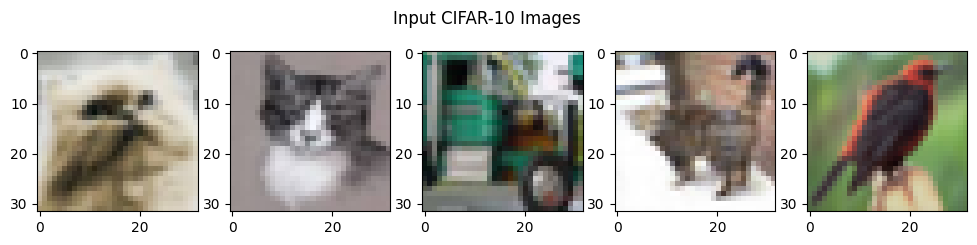

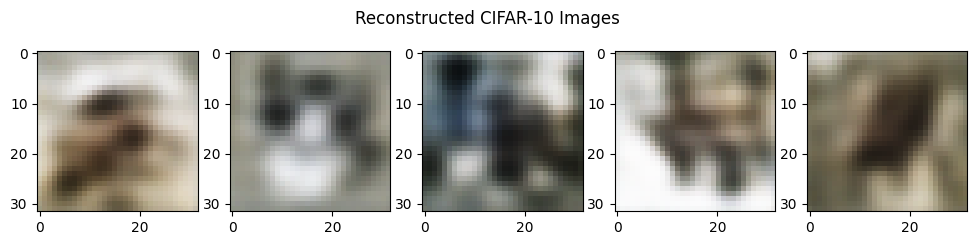

In [25]:
# Plot starting examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('Input CIFAR-10 Images')
ax[0].imshow(np.transpose(img[0].cpu().numpy(), (1,2,0)))
ax[1].imshow(np.transpose(img[1].cpu().numpy(), (1,2,0)))
ax[2].imshow(np.transpose(img[2].cpu().numpy(), (1,2,0)))
ax[3].imshow(np.transpose(img[3].cpu().numpy(), (1,2,0)))
ax[4].imshow(np.transpose(img[4].cpu().numpy(), (1,2,0)))
plt.show()

# Run images though the autoencdoer
output = cifar_model(img)

# Plot reconstructed images
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('Reconstructed CIFAR-10 Images')
ax[0].imshow(np.transpose(output[0].detach().cpu().numpy(), (1,2,0)))
ax[1].imshow(np.transpose(output[1].detach().cpu().numpy(), (1,2,0)))
ax[2].imshow(np.transpose(output[2].detach().cpu().numpy(), (1,2,0)))
ax[3].imshow(np.transpose(output[3].detach().cpu().numpy(), (1,2,0)))
ax[4].imshow(np.transpose(output[4].detach().cpu().numpy(), (1,2,0)))
plt.show()